In [1]:
import numpy as np
np.random.seed(777)
import time
import keras as keras
from keras.layers import GlobalAveragePooling2D
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import decode_predictions
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten
from keras.layers import Input
from keras.models import Model
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.models import load_model
from numpy import array
from numpy import argmax
from sklearn.metrics import accuracy_score
from  numpy import mean
from numpy import std
import matplotlib.pyplot as plt
from keras.optimizers import Adam,SGD
from keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint
from keras.layers import GlobalAveragePooling2D, Concatenate
from keras.layers import BatchNormalization,Dropout
from keras.layers import Lambda
from keras.regularizers import l2
import math
from keras import backend as K
from keras.metrics import categorical_accuracy
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')
from keras.models import load_model

In [2]:
img_height =512
img_width = 512
batch_size =32
input_shape = (img_width, img_height, 3)

In [3]:
train_dir = '/content/drive/MyDrive/BACHAugment'
test_dir = '/content/drive/MyDrive/BACHtest'

# Define the image size and batch size
image_size = (512, 512)
batch_size = 32

random_seed = np.random.seed(1142)
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    validation_split= 0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size= image_size,
    batch_size=batch_size,
    seed = random_seed,
    shuffle=False,
    subset = 'training',
    class_mode='categorical')

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size= image_size,
    batch_size=batch_size,
    seed = random_seed,
    shuffle=False,
    subset = 'validation',
    class_mode='categorical')

test_datagen=ImageDataGenerator(rescale=1./255)
test_generator =test_datagen.flow_from_directory(test_dir,
                                                  target_size=image_size,
                                                  batch_size=batch_size,
                                                  seed=random_seed,
                                                  shuffle=False,
                                                  class_mode='categorical') # set as training data


Found 3368 images belonging to 4 classes.
Found 840 images belonging to 4 classes.
Found 103 images belonging to 4 classes.


In [4]:

nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(val_generator.filenames)
predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))

nb_test_samples = len(test_generator.filenames)
predict_size_test = int(math.ceil(nb_test_samples / batch_size))
print(nb_train_samples)
print(nb_validation_samples)
print(nb_test_samples)
print(predict_size_train)
print(predict_size_validation)
print(predict_size_test)

3368
840
103
106
27
4


In [5]:
model_name="VGG16"
model = VGG16(include_top=False, weights="imagenet",pooling='avg',input_tensor=Input(shape=input_shape))
model.summary()

58889256/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 512, 512, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 512, 512, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 256, 256, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 256, 256, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 256, 256, 128)     147584    
                                                              

In [6]:
for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 input_1
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool
19 global_average_pooling2d


In [7]:
image_input =model.input
x1 = GlobalAveragePooling2D()(model.get_layer("block2_conv1").output)
x2 = GlobalAveragePooling2D()(model.get_layer("block4_conv1").output)
x3 = GlobalAveragePooling2D()(model.get_layer("block5_conv1").output)
out= Concatenate()([x1,x2,x3])
custom_vgg16_model = Model(image_input , out)
custom_vgg16_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 512, 512, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 512, 512, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

In [8]:
for layer in custom_vgg16_model.layers[:15]:
    layer.trainable = False
custom_vgg16_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 512, 512, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 512, 512, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

In [9]:
extracted_features_dir = '/content/drive/MyDrive/BACH-Results/VGG16DCNN/'
#Saving features of the training images
bottleneck_features_train = custom_vgg16_model.predict(train_generator)
np.save(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy', bottleneck_features_train)

106/106 [==============================] - 1610s 15s/step


In [10]:
# Saving features of the validation images
bottleneck_features_validation = custom_vgg16_model.predict(val_generator)
np.save(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy', bottleneck_features_validation)

27/27 [==============================] - 386s 15s/step


In [11]:
# Saving features of the test images
bottleneck_features_test = custom_vgg16_model.predict(test_generator)
np.save(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy', bottleneck_features_test)

4/4 [==============================] - 65s 21s/step


In [12]:
train_data = np.load(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy')
validation_data = np.load(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy')
test_data = np.load(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy')

In [13]:
print(train_data.shape)
print(validation_data.shape)
print(test_data.shape)

(3368, 1152)
(840, 1152)
(103, 1152)


In [14]:
train_labels=train_generator.classes
train_labels=train_labels = keras.utils.to_categorical(train_labels, num_classes=4)
validation_labels=val_generator.classes
validation_labels = keras.utils.to_categorical(validation_labels, num_classes=4)
test_labels=test_generator.classes
test_labels=keras.utils.to_categorical(test_labels,num_classes=4)

In [15]:

model = Sequential()
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax',name= 'output'))

adam_opt2=Adam(lr = 0.001, beta_1=0.6, beta_2=0.8, amsgrad=True)

model.compile(optimizer=adam_opt2, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels,
                    epochs=1000,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    verbose= 2)


Epoch 1/1000
106/106 - 1s - loss: 1.4726 - accuracy: 0.4650 - val_loss: 1.0142 - val_accuracy: 0.5952 - 1s/epoch - 10ms/step
Epoch 2/1000
106/106 - 0s - loss: 1.0560 - accuracy: 0.5472 - val_loss: 0.9584 - val_accuracy: 0.6214 - 321ms/epoch - 3ms/step
Epoch 3/1000
106/106 - 0s - loss: 0.9895 - accuracy: 0.5903 - val_loss: 0.8911 - val_accuracy: 0.6381 - 323ms/epoch - 3ms/step
Epoch 4/1000
106/106 - 0s - loss: 0.8884 - accuracy: 0.6271 - val_loss: 0.8197 - val_accuracy: 0.6762 - 329ms/epoch - 3ms/step
Epoch 5/1000
106/106 - 0s - loss: 0.8501 - accuracy: 0.6535 - val_loss: 0.7805 - val_accuracy: 0.7131 - 328ms/epoch - 3ms/step
Epoch 6/1000
106/106 - 0s - loss: 0.8083 - accuracy: 0.6707 - val_loss: 0.7395 - val_accuracy: 0.7071 - 309ms/epoch - 3ms/step
Epoch 7/1000
106/106 - 0s - loss: 0.7581 - accuracy: 0.7001 - val_loss: 0.7318 - val_accuracy: 0.7226 - 320ms/epoch - 3ms/step
Epoch 8/1000
106/106 - 0s - loss: 0.7117 - accuracy: 0.7218 - val_loss: 0.7397 - val_accuracy: 0.7107 - 304ms/epo

In [16]:
import pickle

# Save model weights
model.save_weights('/content/drive/MyDrive/BACH-Results/VGG16DCNN/BACH-VGG16-DCNN.h5')

# Save training history
with open('/content/drive/MyDrive/BACH-Results/VGG16DCNN/BACH-VGG16_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [17]:
import csv

train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

# Prepare the data to be saved in the CSV file
data = list(zip(train_loss, train_accuracy, val_loss, val_accuracy))

# Define the CSV file path
csv_file_path = '/content/drive/MyDrive/BACH-Results/VGG16DCNN/metrics_history.csv'

# Write the data to the CSV file
with open(csv_file_path, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Train Loss', 'Train Accuracy', 'Validation Loss', 'Validation Accuracy'])
    writer.writerows(data)

print("Metrics history saved to", csv_file_path)

Metrics history saved to /content/drive/MyDrive/BACH-Results/VGG16DCNN/metrics_history.csv


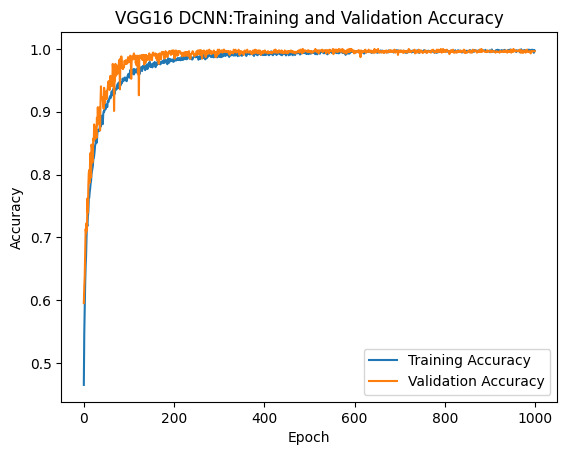

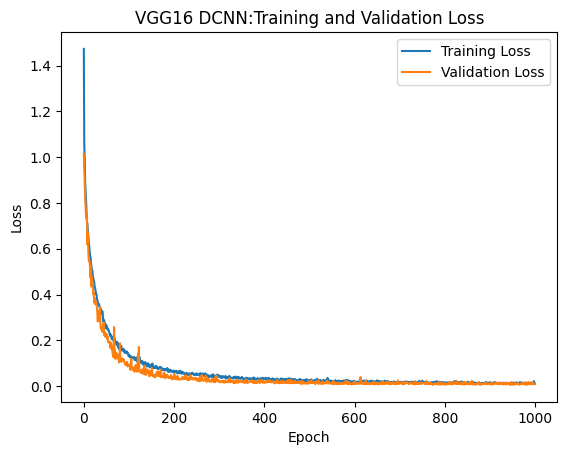

In [36]:
def plot_curves(history, save_dir):
    # Get training and validation accuracy
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    # Get training and validation loss
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Create subdirectory for saving plots
    os.makedirs(save_dir, exist_ok=True)

    # Plot training and validation accuracy
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title('VGG16 DCNN:Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(os.path.join(save_dir, 'accuracy.png'))
    plt.show()
    plt.close()

    # Plot training and validation loss
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('VGG16 DCNN:Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(os.path.join(save_dir, 'loss.png'))
    plt.show()
    plt.close()

plot_curves(history , '/content/drive/MyDrive/BACH-Results/VGG16DCNN')

## Evaluation

In [19]:
preds = model.predict(validation_data)
predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in validation_labels]
print('Validation Accuracy={}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

27/27 [==============================] - 0s 1ms/step
Validation Accuracy=0.9964285714285714


In [20]:
preds = model.predict(test_data)
predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
#cm = confusion_matrix(y_pred=predictions, y_true=y_true)
print('Test Accuracy={}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

4/4 [==============================] - 0s 3ms/step
Test Accuracy=0.7572815533980582


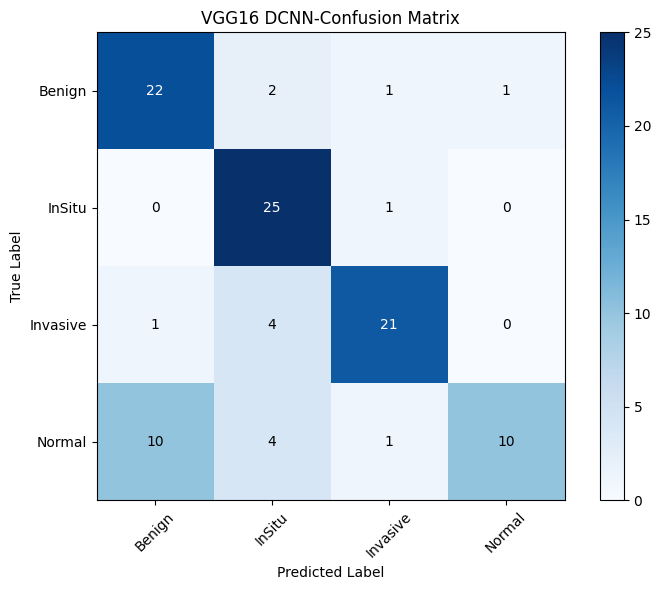

In [21]:
from sklearn.metrics import confusion_matrix

# Convert predictions into labels (assuming one-hot encoding)
predicted_labels = predictions

# Get the true labels from the test generator
true_labels = y_true

# Get the class labels from the test generator
class_labels = list(test_generator.class_indices.keys())

# Create the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('VGG16 DCNN-Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations in each cell
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/BACH-Results/VGG16DCNN/ConfusionMatrix')
plt.show()

In [22]:
from sklearn.metrics import classification_report as cr
print(cr(true_labels , predicted_labels))

              precision    recall  f1-score   support

           0       0.67      0.85      0.75        26
           1       0.71      0.96      0.82        26
           2       0.88      0.81      0.84        26
           3       0.91      0.40      0.56        25

    accuracy                           0.76       103
   macro avg       0.79      0.75      0.74       103
weighted avg       0.79      0.76      0.74       103



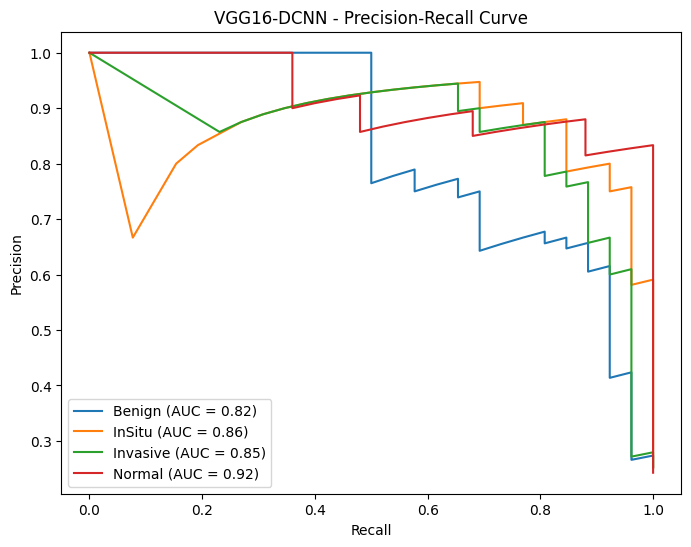

Benign: PR AUC = 0.82
InSitu: PR AUC = 0.86
Invasive: PR AUC = 0.85
Normal: PR AUC = 0.92


In [23]:
from sklearn.metrics import precision_recall_curve , auc
from tensorflow.keras.utils import to_categorical

def plot_precision_recall_curve(y_true , y_score , class_labels):
    # Compute precision, recall, and thresholds for each class
    precision = dict()
    recall = dict()
    thresholds = dict()
    pr_auc = dict()

    for i, label in enumerate(class_labels):
        precision[label], recall[label], thresholds[label] = precision_recall_curve(
            y_true[:, i], y_score[:, i])
        pr_auc[label] = auc(recall[label], precision[label])

    # Plot precision-recall curve for each class
    plt.figure(figsize=(8, 6))

    for label in class_labels:
        plt.plot(recall[label], precision[label], label=f'{label} (AUC = {pr_auc[label]:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('VGG16-DCNN - Precision-Recall Curve')
    plt.legend()
    plt.savefig('/content/drive/MyDrive/BACH-Results/VGG16DCNN/VGG16-DCNN - Precision Recall Curve')
    plt.show()

    # Print precision-recall area for each class
    for label in class_labels:
        print(f'{label}: PR AUC = {pr_auc[label]:.2f}')

plot_precision_recall_curve(test_labels, preds , class_labels)

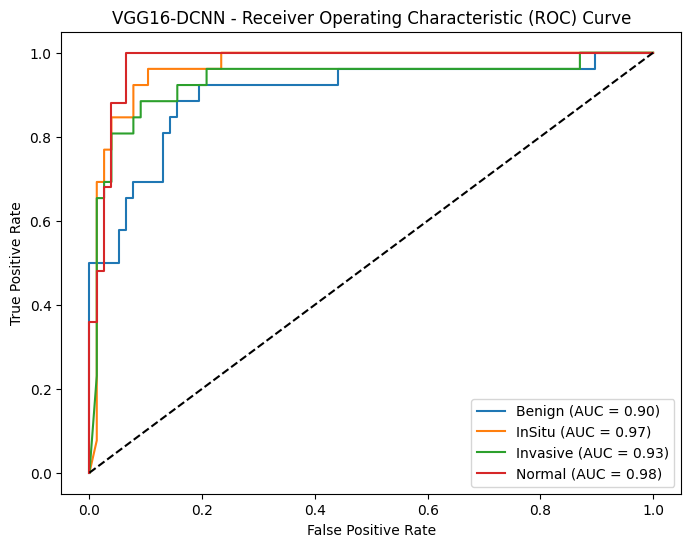

Benign: ROC AUC = 0.90
InSitu: ROC AUC = 0.97
Invasive: ROC AUC = 0.93
Normal: ROC AUC = 0.98


In [24]:
from sklearn.metrics import roc_curve
def plot_roc_curve(y_true ,y_score, class_labels):


    # Compute false positive rate, true positive rate, and thresholds for each class
    fpr = dict()
    tpr = dict()
    thresholds = dict()
    roc_auc = dict()

    for i, label in enumerate(class_labels):
        fpr[label], tpr[label], thresholds[label] = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc[label] = auc(fpr[label], tpr[label])

    # Plot ROC curve for each class
    plt.figure(figsize=(8, 6))

    for label in class_labels:
        plt.plot(fpr[label], tpr[label], label=f'{label} (AUC = {roc_auc[label]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('VGG16-DCNN - Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.savefig('/content/drive/MyDrive/BACH-Results/VGG16DCNN/VGG16-DCNN - ROC')
    plt.show()

    # Print ROC AUC for each class
    for label in class_labels:
        print(f'{label}: ROC AUC = {roc_auc[label]:.2f}')
plot_roc_curve(test_labels, preds , class_labels)

In [25]:
from sklearn.metrics import cohen_kappa_score

kappa = cohen_kappa_score(true_labels , predicted_labels)

print(f'Kappa Value : {kappa}')

Kappa Value : 0.6757743641400151


In [27]:
class_names = [model_name + '-DCNN_' + label for label in class_labels]
class_names

['VGG16-DCNN_Benign',
 'VGG16-DCNN_InSitu',
 'VGG16-DCNN_Invasive',
 'VGG16-DCNN_Normal']

In [28]:
import pandas as pd
train_scores = model.predict(train_data)
val_scores = model.predict(validation_data)
test_scores = model.predict(test_data)

4/4 [==============================] - 0s 4ms/step


In [29]:

train_df = pd.DataFrame(train_scores, columns=class_names)
test_df = pd.DataFrame(test_scores, columns=class_names)
val_df = pd.DataFrame(val_scores, columns=class_names)

train_df['true_class'] = train_generator.labels
val_df['trues_class'] = val_generator.labels
test_df['true_class'] = test_generator.labels

In [30]:
train = pd.read_csv('/content/drive/MyDrive/BACH-Results/train_combined.csv')
val = pd.read_csv('/content/drive/MyDrive/BACH-Results/val_combined.csv')
test = pd.read_csv('/content/drive/MyDrive/BACH-Results/test_combined.csv')

In [31]:
np.all(test['true_class'] == test['true_class'])

True

In [32]:
# Drop common columns from df2 before merging
common_columns = train_df.columns.intersection(train.columns)
train = train.drop(common_columns, axis=1)

train_merge = pd.concat([train ,train_df ],axis=1)
train_merge.head()

,Xception_Benign,Xception_InSitu,Xception_Invasive,Xception_Normal,InceptionResnetV2_Benign,InceptionResnetV2_InSitu,InceptionResnetV2_Invasive,InceptionResnetV2_Normal,VGG16-DCNN_Benign,VGG16-DCNN_InSitu,VGG16-DCNN_Invasive,VGG16-DCNN_Normal,true_class
0,0.999800,1.854811e-04,1.159877e-07,1.441731e-05,0.998591,0.001310,1.960942e-05,0.000079,0.985135,1.484134e-02,5.530087e-06,1.843805e-05,0
1,1.000000,7.908130e-09,1.501580e-10,1.307483e-17,0.988379,0.011584,3.509103e-05,0.000001,1.000000,4.420069e-07,1.359400e-10,3.091290e-16,0
2,1.000000,1.268206e-12,3.440754e-12,2.056221e-13,0.999993,0.000001,4.056639e-07,0.000006,0.999995,1.617020e-09,1.213019e-07,5.291721e-06,0
3,1.000000,9.953632e-11,2.854306e-10,9.443541e-11,0.999454,0.000026,7.589285e-05,0.000444,0.999099,8.135502e-05,1.739072e-05,8.021324e-04,0
4,0.999922,7.654073e-05,1.303407e-06,3.705413e-13,0.999936,0.000011,3.645900e-05,0.000016,0.999922,3.265663e-05,4.363835e-05,1.668907e-06,0


In [33]:

# Drop common columns from val_df before merging
common_columns_val = val.columns.intersection(val_df.columns)
val_df = val_df.drop(common_columns_val, axis=1)

# Merge val DataFrame with val_df
val_merge = pd.concat([val, val_df], axis=1)

val_merge.head()

,Xception_Benign,Xception_InSitu,Xception_Invasive,Xception_Normal,trues_class,InceptionResnetV2_Benign,InceptionResnetV2_InSitu,InceptionResnetV2_Invasive,InceptionResnetV2_Normal,VGG16-DCNN_Benign,VGG16-DCNN_InSitu,VGG16-DCNN_Invasive,VGG16-DCNN_Normal
0,1.000000,9.836929e-09,8.743097e-11,1.296717e-12,0,0.997785,2.171978e-03,7.706233e-06,3.571737e-05,0.999901,2.741361e-05,2.571640e-07,7.160279e-05
1,0.999975,2.347197e-05,1.607933e-06,5.832745e-09,0,0.917851,4.554727e-05,2.143408e-04,8.188866e-02,0.999742,2.126110e-04,4.547797e-05,2.490626e-07
2,0.988956,1.170311e-06,1.104303e-02,1.069673e-11,0,0.999953,2.466213e-08,4.669523e-05,6.290062e-08,0.999897,1.216859e-10,1.028348e-04,2.786781e-15
3,0.999996,2.284926e-09,3.608193e-06,1.246549e-08,0,0.986260,9.564799e-03,2.089887e-03,2.084936e-03,0.999988,2.845789e-06,4.105078e-08,9.230157e-06
4,1.000000,8.450869e-12,7.249892e-17,4.616821e-20,0,0.999968,2.884869e-05,8.664372e-07,2.196936e-06,0.999991,8.578698e-06,1.141949e-08,1.227866e-07


In [34]:
# Drop common columns from test_df before merging
common_columns_test = test.columns.intersection(test_df.columns)
test_df = test_df.drop(common_columns_test, axis=1)

# Merge test DataFrame with test_df
test_merge = pd.concat([test, test_df], axis=1)

test_merge.head()

,Xception_Benign,Xception_InSitu,Xception_Invasive,Xception_Normal,true_class,InceptionResnetV2_Benign,InceptionResnetV2_InSitu,InceptionResnetV2_Invasive,InceptionResnetV2_Normal,VGG16-DCNN_Benign,VGG16-DCNN_InSitu,VGG16-DCNN_Invasive,VGG16-DCNN_Normal
0,0.248858,7.472183e-01,3.829919e-03,9.419375e-05,0,0.981194,0.004620,7.740024e-07,1.418572e-02,0.973082,1.371270e-02,4.288686e-10,1.320546e-02
1,1.000000,1.157398e-09,1.848351e-08,4.793751e-17,0,0.999924,0.000068,8.243710e-06,4.211474e-08,0.991812,8.187751e-03,4.541505e-09,1.125504e-10
2,0.999387,1.293089e-06,6.119487e-04,3.558840e-11,0,0.985574,0.012425,1.995059e-03,6.481806e-06,0.999962,3.730049e-05,3.594845e-07,1.015155e-17
3,0.974065,2.577940e-02,1.447871e-06,1.542108e-04,0,0.994737,0.004969,1.315473e-05,2.812535e-04,1.000000,2.046393e-07,7.795865e-13,2.151870e-09
4,0.999997,2.633827e-06,1.424173e-07,4.900670e-11,0,0.996202,0.003773,1.559816e-05,9.385542e-06,0.683852,3.161379e-01,1.024711e-05,2.737387e-12


In [35]:
train_merge.to_csv('/content/drive/MyDrive/BACH-Results/train_combined.csv', index=False)
test_merge.to_csv('/content/drive/MyDrive/BACH-Results/test_combined.csv', index=False)
val_merge.to_csv('/content/drive/MyDrive/BACH-Results/val_combined.csv', index=False)